# 2. n-gram 기반 통계 언어 모델 구현

이 노트북에서는 n-gram 모델을 구현하여 통계적 언어 모델의 기본 원리를 학습합니다.

## 학습 목표
- n-gram 모델의 수학적 원리 이해하기
- 동시출현 행렬(co-occurrence matrix) 구축하기
- 조건부 확률 $P(w_i | w_{i-1})$ 계산하기
- 손실 함수(Negative Log Likelihood) 구현하고 평가하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter
import math

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

## 2.1 전처리 결과 불러오기

이전 노트북에서 저장한 전처리 결과를 불러옵니다.

In [2]:
# 전처리 결과 불러오기
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)
    
    tokenized_corpus = preprocessing_results['tokenized_corpus']
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    word_counts = preprocessing_results['word_counts']
    
    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
    print(f"문장 수: {len(tokenized_corpus)}")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
문장 수: 10


## 2.2 n-gram 추출 함수 구현

텍스트에서 n-gram을 추출하는 함수를 구현합니다. n-gram은 연속된 n개의 단어 시퀀스를 의미합니다.

In [3]:
def extract_ngrams(sentences, n=2):
    """문장들에서 n-gram을 추출하는 함수
    
    Args:
        sentences: 토큰화된 문장 목록
        n: n-gram의 n (기본값: 2, 즉 bigram)
        
    Returns:
        추출된 n-gram 목록
    """
    all_ngrams = []
    
    for sentence in sentences:
        # 문장의 길이가 n보다 작으면 n-gram을 추출할 수 없음
        if len(sentence) < n:
            continue
            
        # n-gram 추출
        sentence_ngrams = [tuple(sentence[i:i+n]) for i in range(len(sentence) - n + 1)]
        all_ngrams.extend(sentence_ngrams)
    
    return all_ngrams

# bigram (n=2) 추출 예시
bigrams = extract_ngrams(tokenized_corpus, n=2)
# trigram (n=3) 추출 예시
trigrams = extract_ngrams(tokenized_corpus, n=3)

print(f"추출된 bigram 수: {len(bigrams)}")
print(f"추출된 trigram 수: {len(trigrams)}")
print("\n샘플 bigram 5개:")
for bigram in bigrams[:5]:
    print(bigram)

추출된 bigram 수: 60
추출된 trigram 수: 50

샘플 bigram 5개:
('자연어', '처리는')
('처리는', '컴퓨터가')
('컴퓨터가', '인간의')
('인간의', '언어를')
('언어를', '이해하고')


## 2.3 동시출현 행렬(Co-occurrence Matrix) 구축

bigram에 대한 동시출현 행렬을 구축합니다. 이 행렬은 단어 쌍 $(w_{i-1}, w_i)$의 출현 빈도를 나타냅니다.

In [4]:
def build_cooccurrence_matrix(ngrams, vocab_size, word_to_id):
    """n-gram에서 동시출현 행렬을 구축하는 함수
    
    Args:
        ngrams: n-gram 목록
        vocab_size: 어휘 사전 크기
        word_to_id: 단어-ID 매핑 딕셔너리
        
    Returns:
        동시출현 행렬 (numpy array)
    """
    # 동시출현 행렬 초기화 (모든 원소가 0인 행렬)
    cooccurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    # n-gram에서 동시출현 빈도 계산
    for ngram in ngrams:
        # 첫 번째 단어는 행 인덱스, 두 번째 단어는 열 인덱스
        # bigram일 경우 (w_{i-1}, w_i)
        prev_word, curr_word = ngram[0], ngram[1]
        prev_id, curr_id = word_to_id[prev_word], word_to_id[curr_word]
        
        # 해당 단어 쌍의 동시출현 빈도 증가
        cooccurrence_matrix[prev_id, curr_id] += 1
    
    return cooccurrence_matrix

# bigram에 대한 동시출현 행렬 구축
vocab_size = len(word_to_id)
cooccurrence_matrix = build_cooccurrence_matrix(bigrams, vocab_size, word_to_id)

print(f"동시출현 행렬 크기: {cooccurrence_matrix.shape}")
print(f"총 동시출현 빈도: {cooccurrence_matrix.sum()}")
print(f"0이 아닌 원소 수: {np.count_nonzero(cooccurrence_matrix)}")

동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 60
0이 아닌 원소 수: 58


## 2.4 조건부 확률 $P(w_i | w_{i-1})$ 계산

동시출현 행렬을 사용하여 조건부 확률 $P(w_i | w_{i-1})$을 계산합니다. 이는 이전 단어 $w_{i-1}$이 주어졌을 때 현재 단어 $w_i$가 나타날 확률입니다.

$$P(w_i | w_{i-1}) = \frac{C(w_{i-1}, w_i)}{C(w_{i-1})}$$

여기서 $C(w_{i-1}, w_i)$는 단어 쌍 $(w_{i-1}, w_i)$의 출현 빈도이고, $C(w_{i-1})$은 단어 $w_{i-1}$의 출현 빈도입니다.

In [5]:
def calculate_conditional_probabilities(cooccurrence_matrix):
    """동시출현 행렬에서 조건부 확률 P(w_i | w_{i-1})을 계산하는 함수
    
    Args:
        cooccurrence_matrix: 동시출현 행렬
        
    Returns:
        조건부 확률 행렬
    """
    # 각 행의 합 계산 (각 단어 w_{i-1}의 출현 빈도)
    row_sums = cooccurrence_matrix.sum(axis=1, keepdims=True)
    
    # 0으로 나누는 것을 방지하기 위해 0인 경우 1로 변경
    row_sums[row_sums == 0] = 1
    
    # 조건부 확률 계산: P(w_i | w_{i-1}) = C(w_{i-1}, w_i) / C(w_{i-1})
    conditional_probabilities = cooccurrence_matrix / row_sums
    
    return conditional_probabilities

# 조건부 확률 계산
conditional_probabilities = calculate_conditional_probabilities(cooccurrence_matrix)

print(f"조건부 확률 행렬 크기: {conditional_probabilities.shape}")
# 0이 아닌 행(단어가 최소 한 번 이상 등장한 경우)의 합은 1이어야 함
non_zero_rows = cooccurrence_matrix.sum(axis=1) > 0
print(f"각 행의 합이 1인지 확인 (0이 아닌 행만): {np.allclose(conditional_probabilities[non_zero_rows].sum(axis=1), 1.0, rtol=1e-10)}")

조건부 확률 행렬 크기: (59, 59)
각 행의 합이 1인지 확인 (0이 아닌 행만): True


## 2.5 조건부 확률 시각화

특정 단어들에 대한 조건부 확률을 시각화합니다.

In [7]:
!pip install koreanize_matplotlib
import koreanize_matplotlib


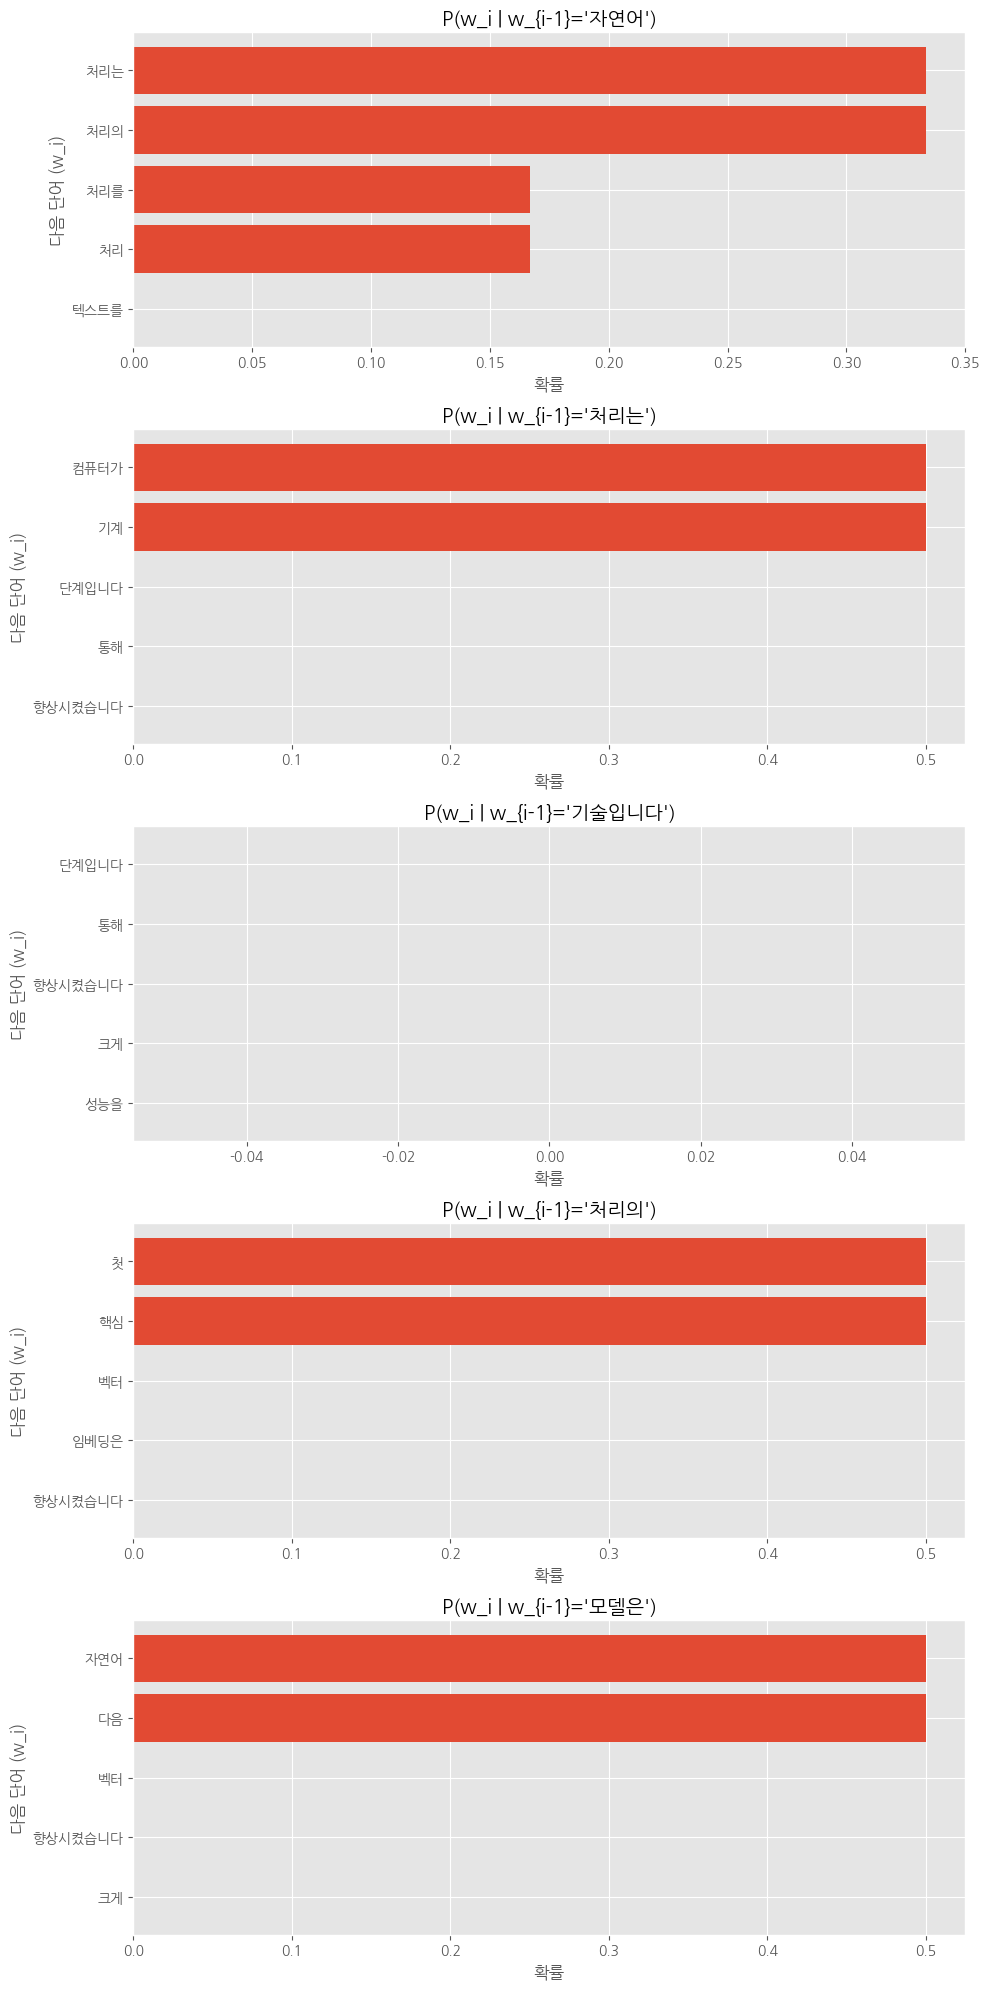

Next Word (w_i)  P(w_i | w_{i-1}='자연어')
            처리는                0.333333
            처리의                0.333333
            처리를                0.166667
             처리                0.166667
           텍스트를                0.000000


In [8]:
def visualize_conditional_probabilities(conditional_probabilities, id_to_word, prev_words, top_n=5):
    """특정 단어들에 대한 조건부 확률을 시각화하는 함수
    
    Args:
        conditional_probabilities: 조건부 확률 행렬
        id_to_word: ID-단어 매핑 딕셔너리
        prev_words: 이전 단어 목록
        top_n: 상위 몇 개의 확률을 표시할지 결정
    """
    fig, axes = plt.subplots(len(prev_words), 1, figsize=(10, 4 * len(prev_words)))
    if len(prev_words) == 1:
        axes = [axes]
    
    for i, prev_word in enumerate(prev_words):
        # 이전 단어의 ID
        try:
            prev_id = word_to_id[prev_word]
        except KeyError:
            print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
            continue
        
        # 해당 단어의 조건부 확률 행 추출
        probs = conditional_probabilities[prev_id]
        
        # 확률이 높은 상위 top_n개 단어 선택
        top_indices = np.argsort(probs)[-top_n:][::-1]
        top_probs = probs[top_indices]
        top_words = [id_to_word[idx] for idx in top_indices]
        
        # 시각화
        axes[i].barh(top_words, top_probs)
        axes[i].set_title(f"P(w_i | w_{{i-1}}='{prev_word}')", fontsize=14)
        axes[i].set_xlabel('확률', fontsize=12)
        axes[i].set_ylabel('다음 단어 (w_i)', fontsize=12)
        axes[i].invert_yaxis()  # 확률이 높은 단어를 위쪽에 표시
    
    plt.tight_layout()
    plt.show()

# 특정 단어들에 대한 조건부 확률 시각화
# 가장 빈도가 높은 단어들 중 일부 선택
most_common_words = [word for word, _ in word_counts.most_common(5)]
visualize_conditional_probabilities(conditional_probabilities, id_to_word, most_common_words)

# 결과를 pandas DataFrame으로 변환하여 테이블 형태로 확인
def display_conditional_probability_table(conditional_probabilities, word_to_id, id_to_word, prev_word, top_n=5):
    """특정 단어에 대한 조건부 확률을 테이블 형태로 표시하는 함수"""    
    try:
        prev_id = word_to_id[prev_word]
    except KeyError:
        print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
        return None
    
    probs = conditional_probabilities[prev_id]
    top_indices = np.argsort(probs)[-top_n:][::-1]
    top_probs = probs[top_indices]
    top_words = [id_to_word[idx] for idx in top_indices]
    
    # DataFrame 생성
    df = pd.DataFrame({
        'Next Word (w_i)': top_words,
        f'P(w_i | w_{{i-1}}=\'{prev_word}\')': top_probs
    })
    
    return df

# 예시: 첫 번째 단어에 대한 조건부 확률 테이블
example_word = most_common_words[0]
cond_prob_table = display_conditional_probability_table(conditional_probabilities, word_to_id, id_to_word, example_word)
if cond_prob_table is not None:
    print(cond_prob_table.to_string(index=False))

## 2.6 Negative Log Likelihood Loss 구현

n-gram 모델의 성능을 평가하기 위해 Negative Log Likelihood (NLL) 손실 함수를 구현합니다. 

언어 모델의 목표는 주어진 문장의 확률을 최대화하는 것입니다. 문장의 확률은 각 단어의 조건부 확률의 곱으로 계산할 수 있습니다.

$$P(w_1, w_2, \ldots, w_n) = \prod_{i=1}^{n} P(w_i | w_{i-1})$$

수치적 안정성을 위해 로그 확률을 사용하며, 손실 함수는 음의 로그 확률(Negative Log Likelihood)로 정의됩니다.

$$\text{NLL} = -\sum_{i=1}^{n} \log P(w_i | w_{i-1})$$

NLL이 낮을수록 모델의 성능이 좋다는 것을 의미합니다.

In [9]:
def calculate_nll(sentence, conditional_probabilities, word_to_id):
    """주어진 문장에 대한 Negative Log Likelihood를 계산하는 함수
    
    Args:
        sentence: 토큰화된 문장
        conditional_probabilities: 조건부 확률 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        
    Returns:
        NLL 값
    """
    if len(sentence) < 2:
        return float('inf')  # 문장이 너무 짧으면 bigram을 추출할 수 없음
    
    nll = 0.0
    for i in range(1, len(sentence)):
        prev_word, curr_word = sentence[i-1], sentence[i]
        
        # 단어가 어휘 사전에 없는 경우 처리
        if prev_word not in word_to_id or curr_word not in word_to_id:
            nll += 10.0  # 큰 패널티 부여
            continue
        
        prev_id, curr_id = word_to_id[prev_word], word_to_id[curr_word]
        prob = conditional_probabilities[prev_id, curr_id]
        
        # 확률이 0인 경우 처리 (smoothing)
        if prob == 0:
            nll += 10.0  # 큰 패널티 부여
        else:
            nll += -np.log(prob)
    
    return nll

# 예시 문장들에 대한 NLL 계산
example_sentences = [
    tokenized_corpus[0],  # 실제 말뭉치에서 첫 번째 문장
    tokenized_corpus[0][::-1],  # 첫 번째 문장을 역순으로 배열 (이상한 문장)
    ['자연어', '처리', '기술'],  # 간단한 문장
    ['인공지능', '기술', '발전']  # 다른 간단한 문장
]

print("문장별 Negative Log Likelihood:")
for i, sentence in enumerate(example_sentences):
    nll = calculate_nll(sentence, conditional_probabilities, word_to_id)
    print(f"문장 {i+1}: {' '.join(sentence)}, NLL = {nll:.4f}")

문장별 Negative Log Likelihood:
문장 1: 자연어 처리는 컴퓨터가 인간의 언어를 이해하고 처리하는 기술입니다, NLL = 1.7918
문장 2: 기술입니다 처리하는 이해하고 언어를 인간의 컴퓨터가 처리는 자연어, NLL = 70.0000
문장 3: 자연어 처리 기술, NLL = 11.7918
문장 4: 인공지능 기술 발전, NLL = 20.0000


## 2.7 다음 단어 예측 함수 구현

n-gram 모델을 사용하여 주어진 단어 다음에 올 가능성이 높은 단어를 예측하는 함수를 구현합니다.

In [10]:
def predict_next_word(prev_word, conditional_probabilities, word_to_id, id_to_word, top_n=5):
    """주어진 단어 다음에 올 가능성이 높은 단어들을 예측하는 함수
    
    Args:
        prev_word: 이전 단어
        conditional_probabilities: 조건부 확률 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        top_n: 상위 몇 개의 예측을 반환할지 결정
        
    Returns:
        예측된 단어와 확률의 리스트
    """
    # 단어가 어휘 사전에 없는 경우 처리
    if prev_word not in word_to_id:
        print(f"단어 '{prev_word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []
    
    prev_id = word_to_id[prev_word]
    probs = conditional_probabilities[prev_id]
    
    # 확률이 높은 상위 top_n개 단어 선택
    top_indices = np.argsort(probs)[-top_n:][::-1]
    
    # 예측 결과 생성
    predictions = []
    for idx in top_indices:
        if probs[idx] > 0:  # 확률이 0인 경우 제외
            predictions.append((id_to_word[idx], probs[idx]))
    
    return predictions

# 예시: 특정 단어 다음에 올 가능성이 높은 단어 예측
example_words = most_common_words[:2]  # 가장 빈번한 단어 2개
for word in example_words:
    predictions = predict_next_word(word, conditional_probabilities, word_to_id, id_to_word)
    print(f"\n'{word}' 다음에 올 가능성이 높은 단어:")
    for next_word, prob in predictions:
        print(f"  {next_word}: {prob:.4f}")


'자연어' 다음에 올 가능성이 높은 단어:
  처리는: 0.3333
  처리의: 0.3333
  처리를: 0.1667
  처리: 0.1667

'처리는' 다음에 올 가능성이 높은 단어:
  컴퓨터가: 0.5000
  기계: 0.5000


## 2.8 결과 저장

후속 분석을 위해 n-gram 모델 결과를 저장합니다.

In [11]:
# n-gram 모델 결과 저장
ngram_results = {
    'bigrams': bigrams,
    'trigrams': trigrams,
    'cooccurrence_matrix': cooccurrence_matrix,
    'conditional_probabilities': conditional_probabilities
}

with open('ngram_results.pkl', 'wb') as f:
    pickle.dump(ngram_results, f)

print("n-gram 모델 결과가 'ngram_results.pkl' 파일에 저장되었습니다.")

n-gram 모델 결과가 'ngram_results.pkl' 파일에 저장되었습니다.


## 2.9 요약 및 다음 단계

이 노트북에서는 n-gram 기반 통계 언어 모델을 구현했습니다. 주요 단계는 다음과 같습니다:

1. n-gram 추출 함수 구현
2. 동시출현 행렬(co-occurrence matrix) 구축
3. 조건부 확률 $P(w_i | w_{i-1})$ 계산
4. 조건부 확률 시각화 및 테이블 표시
5. Negative Log Likelihood Loss 구현
6. 다음 단어 예측 함수 구현

n-gram 모델은 단순하지만 효과적인 통계적 언어 모델입니다. 그러나 어휘 크기가 커지면 희소성 문제가 발생하며, 장거리 의존성을 포착하기 어렵다는 한계가 있습니다.

다음 노트북에서는 GloVe 임베딩을 구현하여 이러한 한계를 극복해보겠습니다.